In [1]:
# 16/01/2022
# Francisco Domínguez Mateos
# Fourier Features Net and Nerf
# From: https://github.com/matajoh/fourier_feature_nets
#       https://colab.research.google.com/github/ndahlquist/pytorch-fourier-feature-networks/blob/master/demo.ipynb

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
import torch.nn.functional as F

#from tqdm.notebook import tqdm as tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def img_tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

    return tensor

def plot(xs, ys, xlim=(-3, 3), ylim=(-3, 3)):
  fig, ax = plt.subplots()
  ax.plot(xs, ys, linewidth=5)
  # ax.set_aspect('equal')
  ax.grid(True, which='both')
  
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)

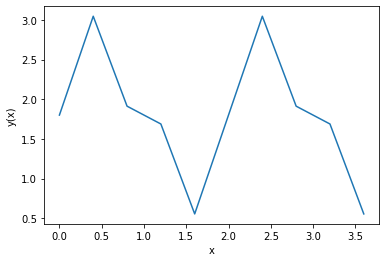

In [203]:
def func(t):
    return 2 + np.sin(t * np.pi) + 0.5*np.sin(2*t*np.pi) - 0.2*np.cos(5*t*np.pi)

num_samples = 10
sample_rate = 1
x_np = np.linspace(0, 4, num_samples * sample_rate, endpoint=False)
y_np = func(x_np)
x=torch.tensor(x_np).float().contiguous().view(-1,1).to(device)
y=torch.tensor(y_np).float().contiguous().view(-1,1).to(device)
plt.xlabel("x")
plt.ylabel("y(x)")
plt.plot(x_np, y_np)

In [204]:
x.shape

torch.Size([10, 1])

In [205]:
y.shape

torch.Size([10, 1])

In [206]:
model=nn.Sequential(
    nn.Linear(1,32),
    nn.ReLU(),
    nn.Linear(32,32),
    nn.ReLU(),
    nn.Linear(32,1)
).to(device)

Epoch 0, loss = 1.931
Epoch 1000, loss = 0.673
Epoch 2000, loss = 0.510
Epoch 3000, loss = 0.485


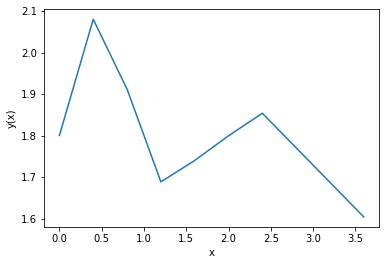

In [207]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

#for epoch in tqdm(range(400)):
for epoch in range(4000):
    optimizer.zero_grad()

    generated = model(x)

    loss = torch.nn.functional.l1_loss(y, generated)

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
plt.xlabel("x")
plt.ylabel("y(x)")
pred_np=generated.cpu().detach().numpy()
plt.plot(x_np, pred_np)

In [208]:
def encoder(x,mapping_size=32,scale=10):
    mapping_size2=mapping_size//2
    #B = (torch.randn((1, mapping_size2)) * scale).to(device)
    #B = torch.eye(1,1).to(device)
    rang=np.arange(0,mapping_size2)+1
    B = torch.Tensor([rang]).to(device)*scale
    encoded=2*np.pi*x @ B
    encoded=torch.cat([torch.sin(encoded),torch.cos(encoded)],dim=1)
    print(B.shape)
    print(x.shape)
    print(encoded.shape)
    return encoded

In [214]:
mapping_size=16
scale=0.1
encoded=encoder(x,mapping_size,scale)
x_all_np=np.linspace(0, 4, 100, endpoint=False)
x_all=torch.tensor(x_all_np).float().contiguous().view(-1,1).to(device)
encoded_all=encoder(x_all,mapping_size,scale)

torch.Size([1, 8])
torch.Size([10, 1])
torch.Size([10, 16])
torch.Size([1, 8])
torch.Size([100, 1])
torch.Size([100, 16])


In [215]:
#print(encoded)

In [216]:
model=nn.Sequential(
    nn.Linear(mapping_size,32),
    nn.ReLU(),
    nn.Linear(32,32),
    nn.ReLU(),
    nn.Linear(32,1)
).to(device)

In [217]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

#for epoch in tqdm(range(400)):
for epoch in range(4000):
    optimizer.zero_grad()

    generated = model(encoded)

    loss = torch.nn.functional.l1_loss(y, generated)

    loss.backward()
    optimizer.step()

    if epoch % 1000//1 == 0:
        print('Epoch %d, loss = %.03f' % (epoch, float(loss)))

Epoch 0, loss = 1.824
Epoch 1000, loss = 0.034
Epoch 2000, loss = 0.000
Epoch 3000, loss = 0.001


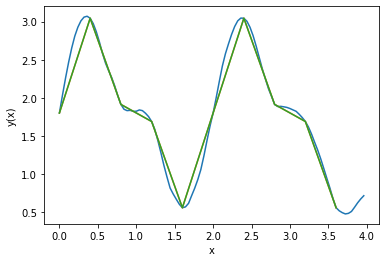

In [218]:
plt.xlabel("x")
plt.ylabel("y(x)")
generated_all=model(encoded_all)
pred_all_np=generated_all.cpu().detach().numpy()
pred_np=generated.cpu().detach().numpy()
plt.plot(x_all_np, pred_all_np)
plt.plot(x_np, pred_np)
plt.xlabel("x")
plt.ylabel("y(x)")
plt.plot(x_np, y_np)